## Question 2.b et 2.c

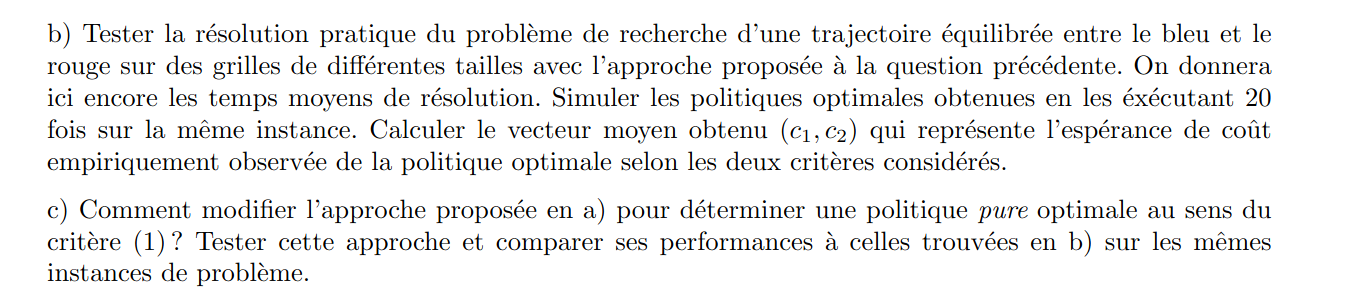

In [1]:
from Env import EnvLabyrinthe
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from gurobipy import *
import time

In [2]:
discount_factor = 0.9

def get_pred_by_action(MDPbi,state,action) :
     
    list_pred_by_action = list()    
    
    for pred in range(len(MDPbi)) :
        
            
        for choice in MDPbi[pred][action] :

            if choice[0] == state  : # si le prochain état = state

                list_pred_by_action.append((choice,pred))
                
    return list_pred_by_action


def get_first_member_matrix_and_obj(MDPbi,discount_factor,nb_obs,nb_actions,infos_state_dict) :
    
    objective_matrix = np.zeros((2,nb_obs,nb_actions))
    # Autant de contraintes que d'état
    first_member_matrix = np.zeros((nb_obs,nb_obs,nb_actions)) # (state,pred,action)
    
    for state in range(nb_obs) :
        
        first_member_matrix[state,state,:] = 1
        
        # first_member_matrix[state,action] += 
        for action in range(len(MDPbi[state])) :
            
            if state == nb_obs-1 :
                objective_matrix[0,state,action] = 2 + 1e-8
                objective_matrix[1,state,action] = 2 + 1e-8
            elif infos_state_dict[state] == 2 : # bleu
                objective_matrix[0,state,action] = 2
                objective_matrix[1,state,action] = 0
            elif infos_state_dict[state] == 3 : # rouge
                objective_matrix[0,state,action] = 0
                objective_matrix[1,state,action] = 2
            else :
                objective_matrix[0,state,action] = 1
                objective_matrix[1,state,action] = 1
            
            pred_by_action = get_pred_by_action(MDPbi,state,action)
            
            for pred in pred_by_action : # pred : (predecesseur,proba,(r1,r2),done)

                first_member_matrix[state,pred[1],action] = first_member_matrix[state,pred[1],action] - (discount_factor * (pred[0][1]))
    
    return first_member_matrix,objective_matrix

def proportion_rouge_bleu(env,policy) :
    
    nb_bleue = 0
    nb_rouge = 0
    
    state = env.replace_player_init()
    done = False
    cum_sum = 0
    i = 0
    max_iter = 50
    while not done and i < max_iter: 
        
        new_state,reward,done = env.step(np.random.choice(a=np.arange(8),p=np.array(policy[state,:], dtype=np.float32)))
        
        if env.infos_state_dict[new_state] == 2:
            nb_bleue += 1
        elif env.infos_state_dict[new_state] == 3:
            nb_rouge += 1
        
        cum_sum += reward
        state = new_state
        i += 1
    return nb_bleue,nb_rouge,i < max_iter

## Creation des environnements

In [3]:
nb_tests_env = 30

list_environnement = list()
for _ in range(nb_tests_env) :
    env = EnvLabyrinthe(
        nblignes = 6,
        nbcolonnes = 6,
        alea = 1, # 0 : deterministe / 1 : stochastique
        proba_mur = 0.15,
        proba_blanc = 0.45,
        proba_vert = 0,
        proba_bleue = 0.2,
        proba_rouge = 0.2
    )
    list_environnement.append(env)
    
for _ in range(nb_tests_env) :
    env = EnvLabyrinthe(
        nblignes = 7,
        nbcolonnes = 7,
        alea = 1, # 0 : deterministe / 1 : stochastique
        proba_mur = 0.15,
        proba_blanc = 0.45,
        proba_vert = 0,
        proba_bleue = 0.2,
        proba_rouge = 0.2
    )
    list_environnement.append(env)
    
for _ in range(nb_tests_env) :
    env = EnvLabyrinthe(
        nblignes = 9,
        nbcolonnes = 9,
        alea = 1, # 0 : deterministe / 1 : stochastique
        proba_mur = 0.15,
        proba_blanc = 0.45,
        proba_vert = 0,
        proba_bleue = 0.2,
        proba_rouge = 0.2
    )
    list_environnement.append(env)
    
for _ in range(nb_tests_env) :
    env = EnvLabyrinthe(
        nblignes = 10,
        nbcolonnes = 10,
        alea = 1, # 0 : deterministe / 1 : stochastique
        proba_mur = 0.15,
        proba_blanc = 0.45,
        proba_vert = 0,
        proba_bleue = 0.2,
        proba_rouge = 0.2
    )
    list_environnement.append(env)
    
for _ in range(nb_tests_env) :
    env = EnvLabyrinthe(
        nblignes = 11,
        nbcolonnes = 11,
        alea = 1, # 0 : deterministe / 1 : stochastique
        proba_mur = 0.15,
        proba_blanc = 0.45,
        proba_vert = 0,
        proba_bleue = 0.2,
        proba_rouge = 0.2
    )
    list_environnement.append(env)
    
for _ in range(nb_tests_env) :
    env = EnvLabyrinthe(
        nblignes = 10,
        nbcolonnes = 12,
        alea = 1, # 0 : deterministe / 1 : stochastique
        proba_mur = 0.15,
        proba_blanc = 0.45,
        proba_vert = 0,
        proba_bleue = 0.2,
        proba_rouge = 0.2
    )
    list_environnement.append(env)

for _ in range(nb_tests_env) :
    env = EnvLabyrinthe(
        nblignes = 11,
        nbcolonnes = 11,
        alea = 1, # 0 : deterministe / 1 : stochastique
        proba_mur = 0.15,
        proba_blanc = 0.45,
        proba_vert = 0,
        proba_bleue = 0.2,
        proba_rouge = 0.2
    )
    list_environnement.append(env)
    
    

# trier les environnement
list_environnement = sorted(list_environnement, key=lambda x: x.nb_states)
print(len(list_environnement))

210


In [4]:
list_time_mixte = list()

list_prop_blue_mixte = list()
list_prop_red_mixte = list()

list_prop_blue_mixte_mdp = list()
list_prop_red_mixte_mdp = list()

In [5]:
for index_environnement in tqdm(range(len(list_environnement))) :
    
    env = list_environnement[index_environnement]
    MDPbi = env.getMDPBiObj()
    # calcul de la politique
    infos_state_dict = env.infos_state_dict
    nb_states = env.nb_states
    nb_actions = 8

    first_member_matrix,objective_matrix = get_first_member_matrix_and_obj(MDPbi,discount_factor,nb_states,nb_actions,infos_state_dict)

    a = first_member_matrix 
    b = [1.0/(nb_states-1) for _ in range(nb_states)]
    b[(nb_states-1)] = 0.0
    c = objective_matrix 

    nbcont = nb_states
    nbvar = nb_states * nb_actions

    lignes = range(nbcont)
    colonnes = range(nbvar)

    start_time = time.time()
    m = Model("mdp") 
    m.setParam( 'OutputFlag', False )

    # declaration variables de decision
    x = []
    for i in range(nb_states):
        l = list()
        for j in range(nb_actions) :
            l.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name=(f"x{i+1}_{j+1}") ))
        x.append(l)
    z = m.addVar(vtype=GRB.CONTINUOUS,lb=0 ,name="z")

    # maj du modele pour integrer les nouvelles variables
    m.update()

    obj = LinExpr();
    obj = z

    m.setObjective(obj,GRB.MAXIMIZE)

    l= [1.0 for _ in range(2)]

    m.addConstr(quicksum(c[0][i][j]*x[i][j] for j in range(nb_actions) for i in range(nb_states)) - z >= 0, "Controbj 1" )
    m.addConstr(quicksum(c[1][i][j]*x[i][j] for j in range(nb_actions) for i in range(nb_states)) - z >= 0, "Controbj 2" )

    for i in lignes:
        m.addConstr(quicksum(a[i][s][j]*x[s][j] for j in range(nb_actions) for s in range(nb_states)) == b[i], "Contrainte %d" % i)

    m.update()
    start_time = time.time()
    m.optimize()
    end_time = time.time()
    # Récupération de la politique
    d = np.array(x).reshape((nb_states,nb_actions))

    for i in range(nb_states) :
        for j in range(nb_actions) :
            d[i,j] = d[i,j].x

    for i in range(nb_states) :
        d[i,:] /= d.sum(axis = 1)[i]

    l_b = 0
    l_r = 0

    for i in range(20) : 
        nb_bleue,nb_rouge,done = proportion_rouge_bleu(env,d)
        if not done :
            i = i - 1
            continue
        l_b += nb_bleue
        l_r += nb_rouge

    nb_r = 0
    nb_b = 0
    for state in MDPbi :

        if env.infos_state_dict[state] == 2 :
            nb_b += 1
        elif env.infos_state_dict[state] == 3 :
            nb_r += 1
    
    
    if (l_b+l_r) <= 0 :
        env.render()
    
    # Enregistrement des logs
    diff_time = end_time - start_time
    prop_blue = l_b/(l_b+l_r)*100
    prop_blue_mdp = nb_b/(nb_b+nb_r)*100 
    
    
    
    prop_red = l_r/(l_b+l_r)*100
    prop_red_mdp = nb_r/(nb_b+nb_r)*100 
    
    
    list_time_mixte.append(diff_time)

    list_prop_blue_mixte.append(prop_blue)
    list_prop_red_mixte.append(prop_red)

    list_prop_blue_mixte_mdp.append(prop_blue_mdp)
    list_prop_red_mixte_mdp.append(prop_red_mdp)
    
    
    #print(f"Environnement de taille : {nb_states}")
    #print(l_b,l_r)
    #print(f'{l_b/(l_b+l_r)*100}% de bleue et {l_r/(l_b+l_r)*100}% de rouge pour la simulation')
    #print(f'{nb_b/(nb_b+nb_r)*100}% de bleue et {nb_r/(nb_b+nb_r)*100}% de rouge dans le MDP')
    #print(nb_b,nb_r)

  0%|                                                   | 0/210 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2023-10-25


100%|█████████████████████████████████████████| 210/210 [05:49<00:00,  1.67s/it]


In [6]:
l_env = [env.nb_states for env in list_environnement]
print([env.nb_states for env in list_environnement])

[28, 29, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 35, 35, 36, 38, 39, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 64, 66, 67, 67, 69, 69, 69, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 73, 73, 73, 74, 74, 75, 75, 76, 77, 77, 79, 82, 82, 83, 83, 83, 83, 84, 84, 85, 86, 86, 86, 86, 87, 87, 87, 87, 87, 88, 88, 89, 89, 89, 90, 92, 92, 93, 93, 95, 97, 97, 97, 98, 98, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 107, 107, 108, 109, 109, 109, 109, 110, 110, 111, 111, 111, 111]


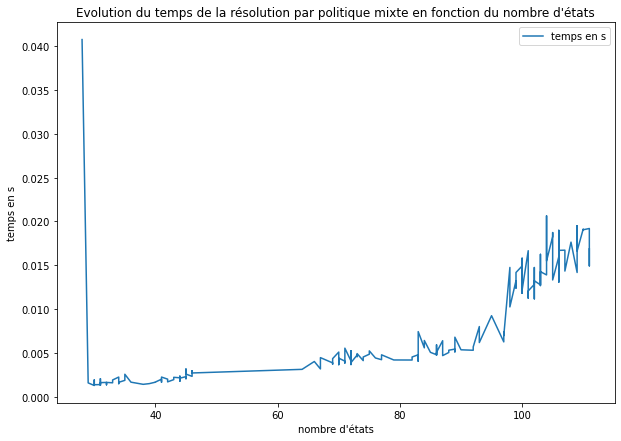

In [7]:
plt.figure(figsize=(10,7))
plt.xlabel("nombre d'états")
plt.ylabel("temps en s")
plt.plot(l_env,list_time_mixte,label="temps en s")
plt.legend()
plt.title("Evolution du temps de la résolution par politique mixte en fonction du nombre d'états")
plt.show()

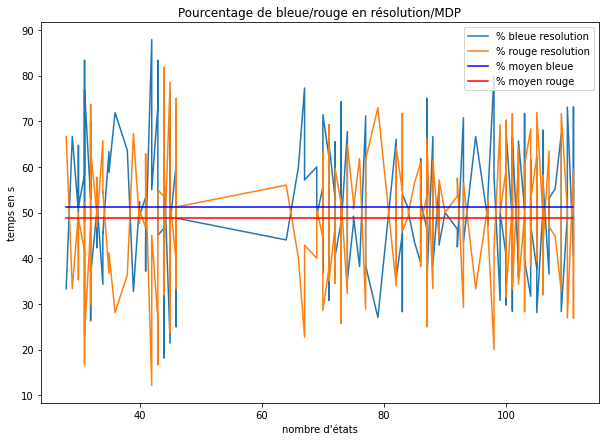

In [8]:
m_blue_mixte = np.array(list_prop_blue_mixte).mean()
m_red_mixte = np.array(list_prop_red_mixte).mean()

plt.figure(figsize=(10,7))
plt.xlabel("nombre d'états")
plt.ylabel("temps en s")
plt.plot(l_env,list_prop_blue_mixte,label="% bleue resolution")
plt.plot(l_env,list_prop_red_mixte,label="% rouge resolution")
plt.plot(l_env,[m_blue_mixte for _ in range(len(l_env))],label="% moyen bleue", c="b")
plt.plot(l_env,[m_red_mixte for _ in range(len(l_env))],label="% moyen rouge", c="r")
#plt.plot(l_env,list_prop_blue_mixte_mdp,label="% bleue MDP")
#plt.plot(l_env,list_prop_red_mixte_mdp,label="% rouge MDP")
plt.legend()
plt.title("Pourcentage de bleue/rouge en résolution/MDP")
plt.show()

## question 2.c

In [9]:
list_prop_blue_pure = list()
list_prop_red_pure = list()

list_prop_blue_pure_mdp = list()
list_prop_red_pure_mdp = list()

list_time_pure = list()

In [10]:
for index_environnement in tqdm(range(len(list_environnement))) :

    env = list_environnement[index_environnement]
    env.replace_player_init()
    MDPbi = env.getMDPBiObj()
    # calcul de la politique
    infos_state_dict = env.infos_state_dict
    nb_states = env.nb_states
    nb_actions = 8

    first_member_matrix,objective_matrix = get_first_member_matrix_and_obj(MDPbi,discount_factor,nb_states,nb_actions,infos_state_dict)
    
    a = first_member_matrix 
    b = [1.0/(nb_states-1) for _ in range(nb_states)]
    b[(nb_states-1)] = 0.0
    c = objective_matrix 

    nbcont = nb_states
    nbvar = nb_states * nb_actions

    lignes = range(nbcont)
    colonnes = range(nbvar)
    
    # declaration du PL bi critère version politique pures
    
    m = Model("mdp")     
    m.setParam( 'OutputFlag', False )    
    # declaration variables de decision
    x = []
    for i in range(nb_states):
        l = list()
        for j in range(nb_actions) :
            l.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name=(f"x{i+1}_{j+1}") ))
        x.append(l)

    d = []
    for i in range(nb_states):
        l = list()
        for j in range(nb_actions) :
            l.append(m.addVar(vtype=GRB.BINARY, lb=0, name=(f"d{i+1}_{j+1}") ))
        d.append(l)    

    z = m.addVar(vtype=GRB.CONTINUOUS , lb=0,name="z")

    # maj du modele pour integrer les nouvelles variables
    m.update()

    obj = LinExpr();
    obj = z
    
    m.setObjective(obj,GRB.MAXIMIZE)

    m.addConstr(quicksum(c[0][i][j]*x[i][j] for j in range(nb_actions) for i in range(nb_states)) >= z, "Controbj 1" )
    m.addConstr(quicksum(c[1][i][j]*x[i][j] for j in range(nb_actions) for i in range(nb_states)) >= z, "Controbj 2" )

    # Definition des contraintes
    for i in lignes:
        m.addConstr(quicksum(a[i][s][j]*x[s][j] for j in range(nb_actions) for s in range(nb_states)) == b[i], "Contrainte %d" % i)

    for i in range(nb_states) :
        for j in range(nb_actions) :
            m.addConstr((1 - discount_factor) * x[i][j] <= d[i][j], "cm %d" % i)

    for i in range(nb_states) :   
        m.addConstr(quicksum(d[i][j] for j in range(nb_actions)) <= 1.0 , "dd %d" % i)  
        
        
        
    start_time = time.time()
    m.optimize()
    end_time = time.time()
    
    # Récupération de la politique
    d = np.array(x).reshape((nb_states,nb_actions))
    
    
    for i in range(nb_states) :
        for j in range(nb_actions) :
            if d[i,j].x >= 0 :
                d[i,j] = d[i,j].x
            else :
                 d[i,j] = 0
            
            
    for i in range(nb_states) :
        if d.sum(axis = 1)[i] == 0 :
            env.render()
            print(d)
        d[i,:] /= d.sum(axis = 1)[i]
    
    # print(d)
    l_b = 0
    l_r = 0

    for i in range(20) : 
        nb_bleue,nb_rouge,done = proportion_rouge_bleu(env,d)
        if not done :
            i = i - 1
            continue
        l_b += nb_bleue
        l_r += nb_rouge

    nb_r = 0
    nb_b = 0
    for state in MDPbi :

        if env.infos_state_dict[state] == 2 :
            nb_b += 1
        elif env.infos_state_dict[state] == 3 :
            nb_r += 1

    if l_b+l_r == 0 :
        env.render()
        print(d)
            
            
    # Enregistrement des logs
    diff_time = end_time - start_time
    prop_blue = l_b/(l_b+l_r)*100
    prop_blue_mdp = nb_b/(nb_b+nb_r)*100 
    
    prop_red = l_r/(l_b+l_r)*100
    prop_red_mdp = nb_r/(nb_b+nb_r)*100 
    
    
    list_time_pure.append(diff_time)

    list_prop_blue_pure.append(prop_blue)
    list_prop_red_pure.append(prop_red)

    list_prop_blue_pure_mdp.append(prop_blue_mdp)
    list_prop_red_pure_mdp.append(prop_red_mdp)

100%|█████████████████████████████████████████| 210/210 [07:02<00:00,  2.01s/it]


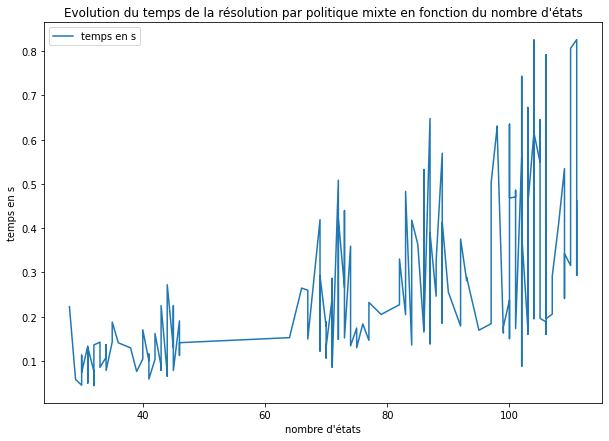

In [11]:
plt.figure(figsize=(10,7))
plt.xlabel("nombre d'états")
plt.ylabel("temps en s")
plt.plot(l_env,list_time_pure,label="temps en s")
plt.legend()
plt.title("Evolution du temps de la résolution par politique mixte en fonction du nombre d'états")
plt.show()

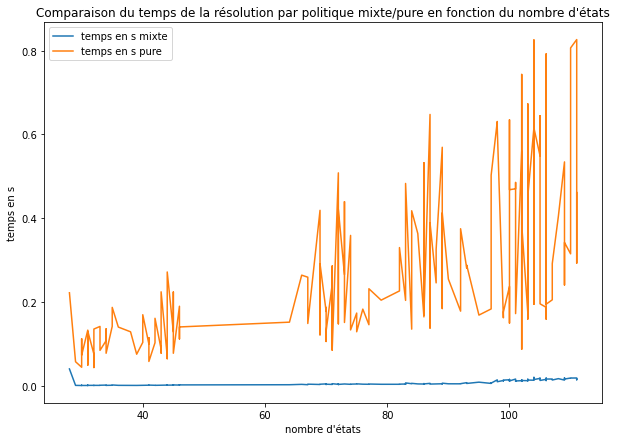

In [12]:
plt.figure(figsize=(10,7))
plt.xlabel("nombre d'états")
plt.ylabel("temps en s")
plt.plot(l_env,list_time_mixte,label="temps en s mixte")
plt.plot(l_env,list_time_pure,label="temps en s pure")
plt.legend()
plt.title("Comparaison du temps de la résolution par politique mixte/pure en fonction du nombre d'états")
plt.show()

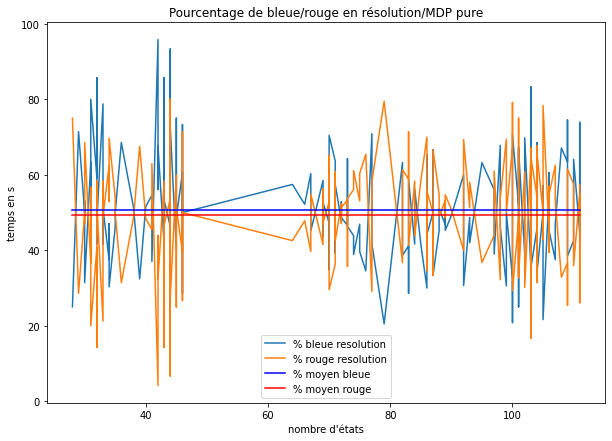

In [13]:
m_blue_pure = np.array(list_prop_blue_pure).mean()
m_red_pure = np.array(list_prop_red_pure).mean()

plt.figure(figsize=(10,7))
plt.xlabel("nombre d'états")
plt.ylabel("temps en s")
plt.plot(l_env,list_prop_blue_pure,label="% bleue resolution")
plt.plot(l_env,list_prop_red_pure,label="% rouge resolution")
plt.plot(l_env,[m_blue_pure for _ in range(len(l_env))],label="% moyen bleue", c="b")
plt.plot(l_env,[m_red_pure for _ in range(len(l_env))],label="% moyen rouge", c="r")
#plt.plot(l_env,list_prop_blue_mixte_mdp,label="% bleue MDP")
#plt.plot(l_env,list_prop_red_mixte_mdp,label="% rouge MDP")
plt.legend()
plt.title("Pourcentage de bleue/rouge en résolution/MDP pure")
plt.show()

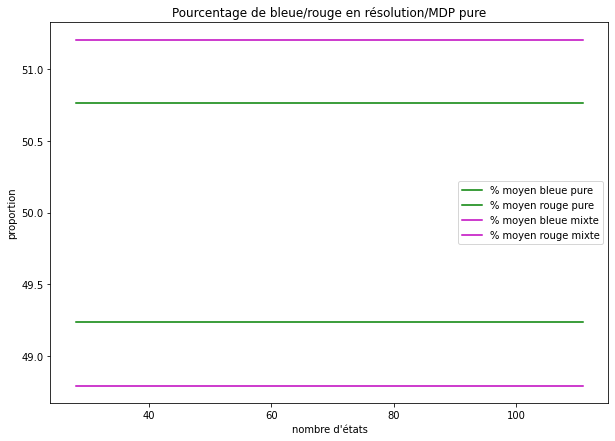

In [14]:
plt.figure(figsize=(10,7))
plt.xlabel("nombre d'états")
plt.ylabel("proportion")
plt.plot(l_env,[m_blue_pure for _ in range(len(l_env))],label="% moyen bleue pure",c='g')
plt.plot(l_env,[m_red_pure for _ in range(len(l_env))],label="% moyen rouge pure", c='g')
plt.plot(l_env,[m_blue_mixte for _ in range(len(l_env))],label="% moyen bleue mixte", c='m')
plt.plot(l_env,[m_red_mixte for _ in range(len(l_env))],label="% moyen rouge mixte", c='m' )
#plt.plot(l_env,list_prop_blue_mixte_mdp,label="% bleue MDP")
#plt.plot(l_env,list_prop_red_mixte_mdp,label="% rouge MDP")
#plt.yticks(np.arange(0,100,10))
plt.legend()
plt.title("Pourcentage de bleue/rouge en résolution/MDP pure")
plt.show()

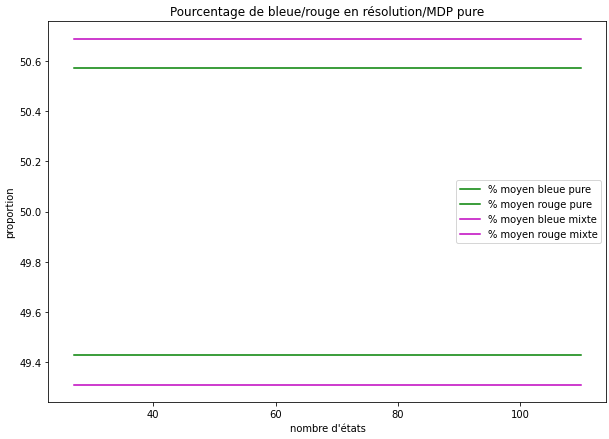